In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import json
import os
import argparse
import re
import warnings
from collections import Counter
from tqdm.notebook import tqdm

# Suppress unnecessary warnings from matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
MAX_LAYER = 6
INPUT_DIR = "ablation_data"
THRESHOLDS = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
OUTPUT_DIR = "analysis"

In [18]:
def convert_name_to_component(component_name):
    if 'pos_embed' in component_name: return 'pos_emb', -1, None
    if 'embed' in component_name: return 'emb', -1, None
    if 'final' in component_name: return 'ln_'+component_name.split('_')[-1][:5],MAX_LAYER, None
    if 'logit' in component_name: return 'logits', MAX_LAYER+1, None
    parts = component_name.replace("hook_","").replace('_in',"").replace("_out","").split(".")[1:]
    if 'ln' in parts[1]:
        return f"{parts[1]}.{parts[2]}.{parts[0]}", int(parts[0]), None
    if 'attn' in parts[1]:
        try:
            return f"{parts[1]}.{parts[2]}.{parts[0]}.{parts[-1]}", int(parts[0]), int(parts[-1])
        except ValueError:
            return f"{parts[1]}.{parts[2]}.{parts[0]}", int(parts[0]), None
    if 'mlp' in parts[1]: return f'{parts[1]}_{parts[0]}', int(parts[0]), None
    return None

In [37]:
def analyze_graph_metrics(G, step, threshold):
    """Calculates a dictionary of metrics for a given graph."""
    if G.number_of_nodes() == 0:
        return {
            'step': step, 'threshold': threshold, 'num_nodes': 0, 'num_edges': 0,
            'density': 0, 'avg_in_strength': 0, 'avg_out_strength': 0,
            'avg_betweenness': 0, 'avg_closeness': 0, 'avg_pagerank': 0
        }

    in_strength = {n: d for n, d in G.in_degree(weight='weight')}
    out_strength = {n: d for n, d in G.out_degree(weight='weight')}
    betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
    closeness = nx.closeness_centrality(G, distance='weight')
    pagerank = nx.pagerank(G, weight='weight')

    metrics = {
        'step': step,
        'threshold': threshold,
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_in_strength': np.mean(list(in_strength.values())),
        'avg_out_strength': np.mean(list(out_strength.values())),
        'avg_betweenness': np.mean(list(betweenness.values())),
        'avg_closeness': np.mean(list(closeness.values())),
        'avg_pagerank': np.mean(list(pagerank.values())),
        # Store full distributions for later plotting
        'in_strength_dist': list(in_strength.values()),
        'out_strength_dist': list(out_strength.values()),
        'edge_weight_dist': [d['weight'] for _, _, d in G.edges(data=True)]
    }
    return metrics
def plot_metrics_over_time(df_metrics, save_dir):
    """
    Plots key metrics over training steps, with induction_log on a secondary y-axis.
    Each metric gets its own subplot, faceted by threshold.
    """
    # Metrics to plot on the primary y-axis
    primary_metrics = [
        'num_nodes', 'num_edges', 'density', 'avg_in_strength', 'avg_out_strength',
        'avg_betweenness', 'avg_closeness', 'avg_pagerank', 'induction_loss'
    ]
    
    # The metric for the secondary y-axis
    secondary_metric = 'induction_log'

    # Calculate the number of rows needed for the subplots
    num_metrics = len(primary_metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 6 * num_metrics))
    
    # Ensure axes is an array even if there's only one subplot
    if num_metrics == 1:
        axes = [axes]

    for i, metric in enumerate(primary_metrics):
        ax1 = axes[i]
        
        # Plot the primary metric on the left y-axis
        sns.lineplot(data=df_metrics, x='step', y=metric, hue='threshold', marker='None', ax=ax1, palette='viridis')
        ax1.set_title(f'Evolution of {metric.replace("_", " ").title()} and Induction Log', fontsize=16)
        ax1.set_xlabel('Training Step', fontsize=12)
        ax1.set_ylabel(metric.replace("_", " ").title(), fontsize=12, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(True, linestyle='--', alpha=0.6)
        
        # Create a secondary y-axis that shares the same x-axis
        ax2 = ax1.twinx()
        
        # Plot the induction_log on the right y-axis
        sns.lineplot(data=df_metrics, x='step', y=secondary_metric, marker='None', ax=ax2, color='red', linestyle='--')
        ax2.set_ylabel(secondary_metric.replace("_", " ").title(), fontsize=12, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Handling legends: get handles and labels from both axes and combine them
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        # To avoid duplicate labels in the legend, we can use a dictionary
        by_label = dict(zip(labels1 + labels2, handles1 + handles2))
        ax1.legend(by_label.values(), by_label.keys(), title='Threshold')
        # Remove the automatically generated legend from the second axis
        if ax2.get_legend():
            ax2.get_legend().remove()


    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for a super title if needed
    
    '''
    # Optional: Save the figure
    save_path = os.path.join(save_dir, 'metrics_and_induction_log_evolution.png')
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Saved temporal metrics plot to {save_path}")
    '''
    plt.show()
    plt.close()

def plot_weight_and_strength_distributions(df, save_dir):
    """Plots the distribution of weights and strengths at different training stages."""
    # Select first, middle, and last step for comparison
    steps = sorted(df['step'].unique())
    if len(steps) > 2:
        steps_to_plot = [steps[0], steps[len(steps) // 2], steps[-1]]
    else:
        steps_to_plot = steps
    
    df_plot = df[df['step'].isin(steps_to_plot)]

    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    # Edge Weights
    edge_data = df_plot.explode('edge_weight_dist')
    sns.violinplot(data=edge_data, x='step', y='edge_weight_dist', hue='threshold', ax=axes[0], palette='plasma')
    axes[0].set_title('Edge Weight Distribution', fontsize=16)
    axes[0].set_xlabel('Training Step')
    axes[0].set_ylabel('Edge Weight (1 - Similarity)')

    # In-Strength
    in_strength_data = df_plot.explode('in_strength_dist')
    sns.violinplot(data=in_strength_data, x='step', y='in_strength_dist', hue='threshold', ax=axes[1], palette='plasma')
    axes[1].set_title('Node In-Strength Distribution', fontsize=16)
    axes[1].set_xlabel('Training Step')
    axes[1].set_ylabel('Weighted In-Degree')
    
    # Out-Strength
    out_strength_data = df_plot.explode('out_strength_dist')
    sns.violinplot(data=out_strength_data, x='step', y='out_strength_dist', hue='threshold', ax=axes[2], palette='plasma')
    axes[2].set_title('Node Out-Strength Distribution', fontsize=16)
    axes[2].set_xlabel('Training Step')
    axes[2].set_ylabel('Weighted Out-Degree')
    
    plt.tight_layout()
    '''
    save_path = os.path.join(save_dir, 'distributions_comparison.png')
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Saved distribution plots to {save_path}")
    '''
    plt.show()
    plt.close()

def analyze_and_plot_link_persistence(graphs_by_step, threshold, save_dir):
    """Analyzes how many times each link appears across all steps."""
    if not graphs_by_step:
        return

    all_edges = []
    for step in sorted(graphs_by_step.keys()):
        G = graphs_by_step[step]
        # Create canonical representation of an edge
        all_edges.extend([(u, v) for u, v in G.edges()])
    
    edge_counts = Counter(all_edges)
    if not edge_counts:
        print("No persistent edges found.")
        return

    persistence_counts = list(edge_counts.values())
    
    plt.figure(figsize=(10, 6))
    sns.histplot(persistence_counts, bins=len(graphs_by_step), discrete=True)
    plt.title(f'Link Persistence Distribution (Threshold={threshold})', fontsize=16)
    plt.xlabel('Number of Steps an Edge Persists', fontsize=12)
    plt.ylabel('Count of Unique Edges', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    '''
    save_path = os.path.join(save_dir, f'link_persistence_thresh_{threshold}.png')
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Saved link persistence plot to {save_path}")
    '''
    plt.show()
    plt.close()
    
    # Optional: Save the most persistent edges
    persistent_df = pd.DataFrame(edge_counts.items(), columns=['edge', 'persistence_count'])
    persistent_df = persistent_df.sort_values('persistence_count', ascending=False)
    csv_path = os.path.join(save_dir, f'persistent_edges_thresh_{threshold}.csv')
    persistent_df.head(50).to_csv(csv_path, index=False)
    print(f"Saved top 50 persistent edges to {csv_path}")

In [20]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    all_files = [f for f in os.listdir(INPUT_DIR) if f.startswith('step') and f.endswith('.csv')]
    if not all_files:
        raise FileNotFoundError
    # Sort files numerically by step number
    all_files.sort(key=lambda f: int(re.search(r'step(\d+)', f).group(1)))
except (FileNotFoundError, AttributeError):
    print(f"Error: No valid 'step_*.csv' files found in '{INPUT_DIR}'.")

In [21]:
with open('induction_data.json') as f:
    ind_data = json.load(f)
with open('loss_data.json') as f:
    loss_data = json.load(f)

In [22]:
all_metrics = []
graphs_by_threshold_and_step = {t: {} for t in THRESHOLDS}

outer_bar = tqdm(all_files, desc="Processing Files")
for filename in outer_bar:
    #print(f"\n--- Reading {filename} ---")
    step_num = int(re.search(r'step(\d+)', filename).group(1))
    file_path = os.path.join(INPUT_DIR, filename)
    df_sim = pd.read_csv(file_path, index_col=0)

    for threshold in THRESHOLDS:
        #print(f"  -> Building graph for threshold={threshold}...")
        
        # Filter for low similarity scores and build adjacency list
        adj_tuples = []
        low_values = df_sim[df_sim < threshold].stack().reset_index()
        low_values.columns = ['source', 'target', 'similarity']
        
        for _, row in low_values.iterrows():
            _, source_layer, _ = convert_name_to_component(row['source'])
            _, target_layer, _ = convert_name_to_component(row['target'])
            
            # Ensure connections are forward-flowing
            if source_layer < target_layer:
                adj_tuples.append((row['source'], row['target'], row['similarity']))

        # Create the graph
        G = nx.DiGraph()
        for source, dest, sim in adj_tuples:
            source_name, source_layer, _ = convert_name_to_component(source)
            target_name, target_layer, _ = convert_name_to_component(dest)
            G.add_node(source_name, layer=source_layer)
            G.add_node(target_name, layer=target_layer)
            G.add_edge(source_name, target_name, weight=(1 - sim)) # Weight = strength
        
        # Analyze and store metrics
        metrics = analyze_graph_metrics(G, step_num, threshold)
        metrics['induction_log'] = ind_data[f"step{step_num}"]["clean"]
        metrics['induction_loss'] = loss_data[f"step{step_num}"]["clean"]
        all_metrics.append(metrics)
        
        graphs_by_threshold_and_step[threshold][step_num] = G

Processing Files:   0%|          | 0/153 [00:00<?, ?it/s]

In [23]:
# Create and save a summary DataFrame
df_metrics = pd.DataFrame(all_metrics)
summary_path = os.path.join(OUTPUT_DIR, 'metrics_summary.csv')
df_metrics.drop(columns=['in_strength_dist', 'out_strength_dist', 'edge_weight_dist']).to_csv(summary_path, index=False)
print(f"\nSaved summary of all metrics to {summary_path}")


Saved summary of all metrics to analysis/metrics_summary.csv


In [25]:
df_metrics.columns

Index(['step', 'threshold', 'num_nodes', 'num_edges', 'density',
       'avg_in_strength', 'avg_out_strength', 'avg_betweenness',
       'avg_closeness', 'avg_pagerank', 'in_strength_dist',
       'out_strength_dist', 'edge_weight_dist', 'induction_log',
       'induction_loss'],
      dtype='object')

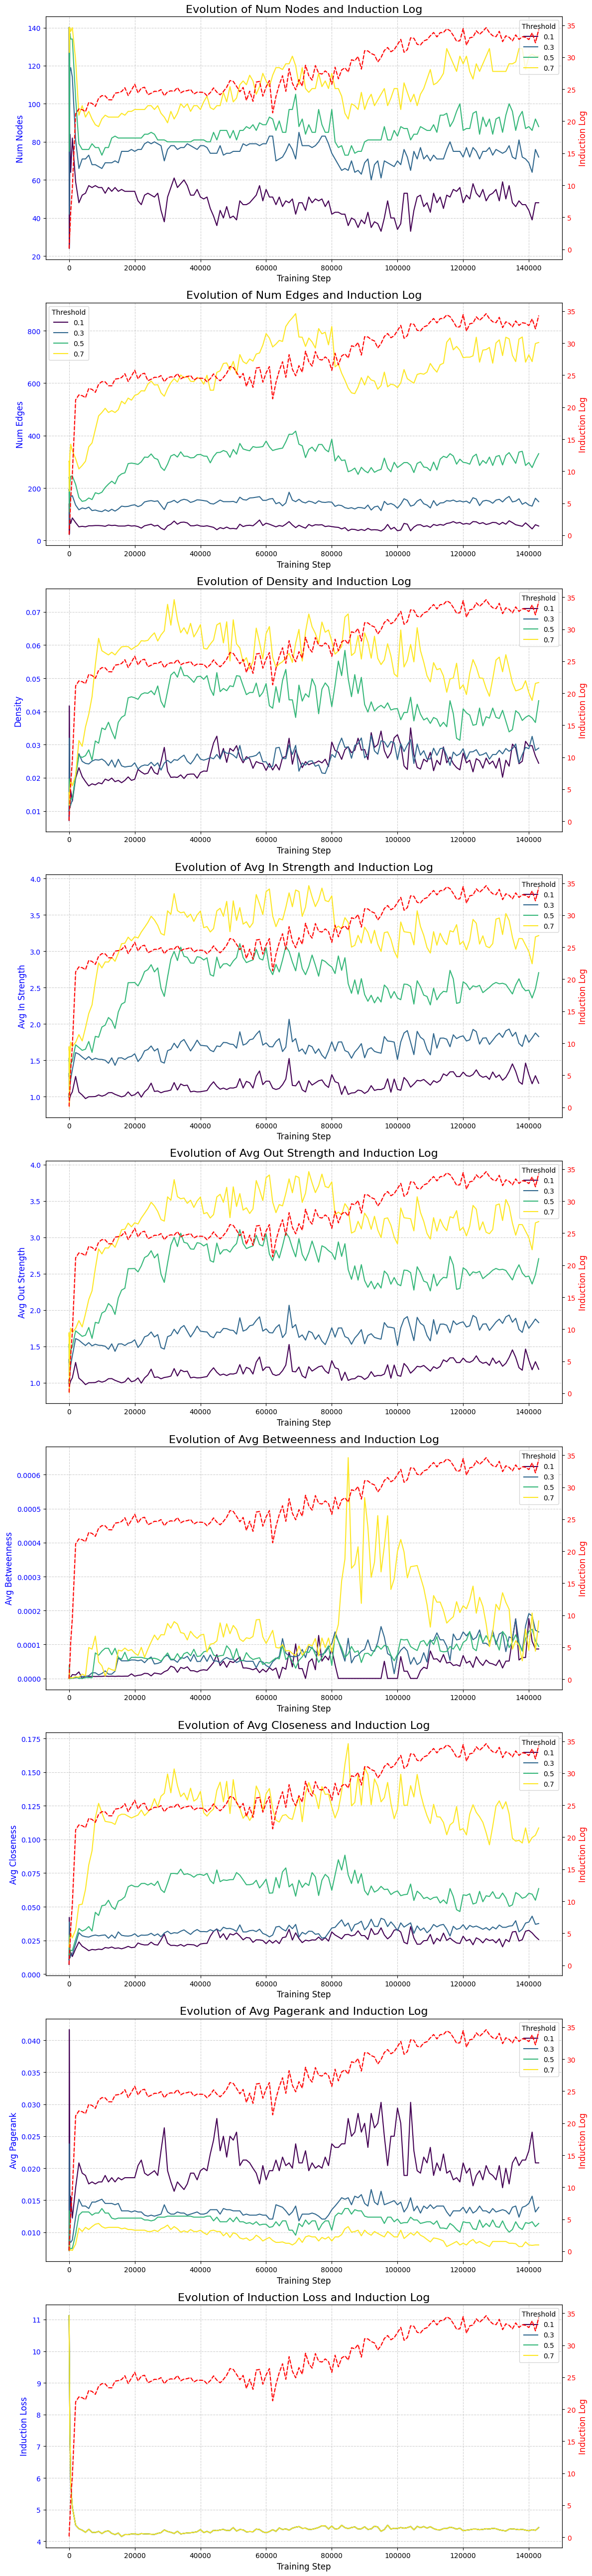

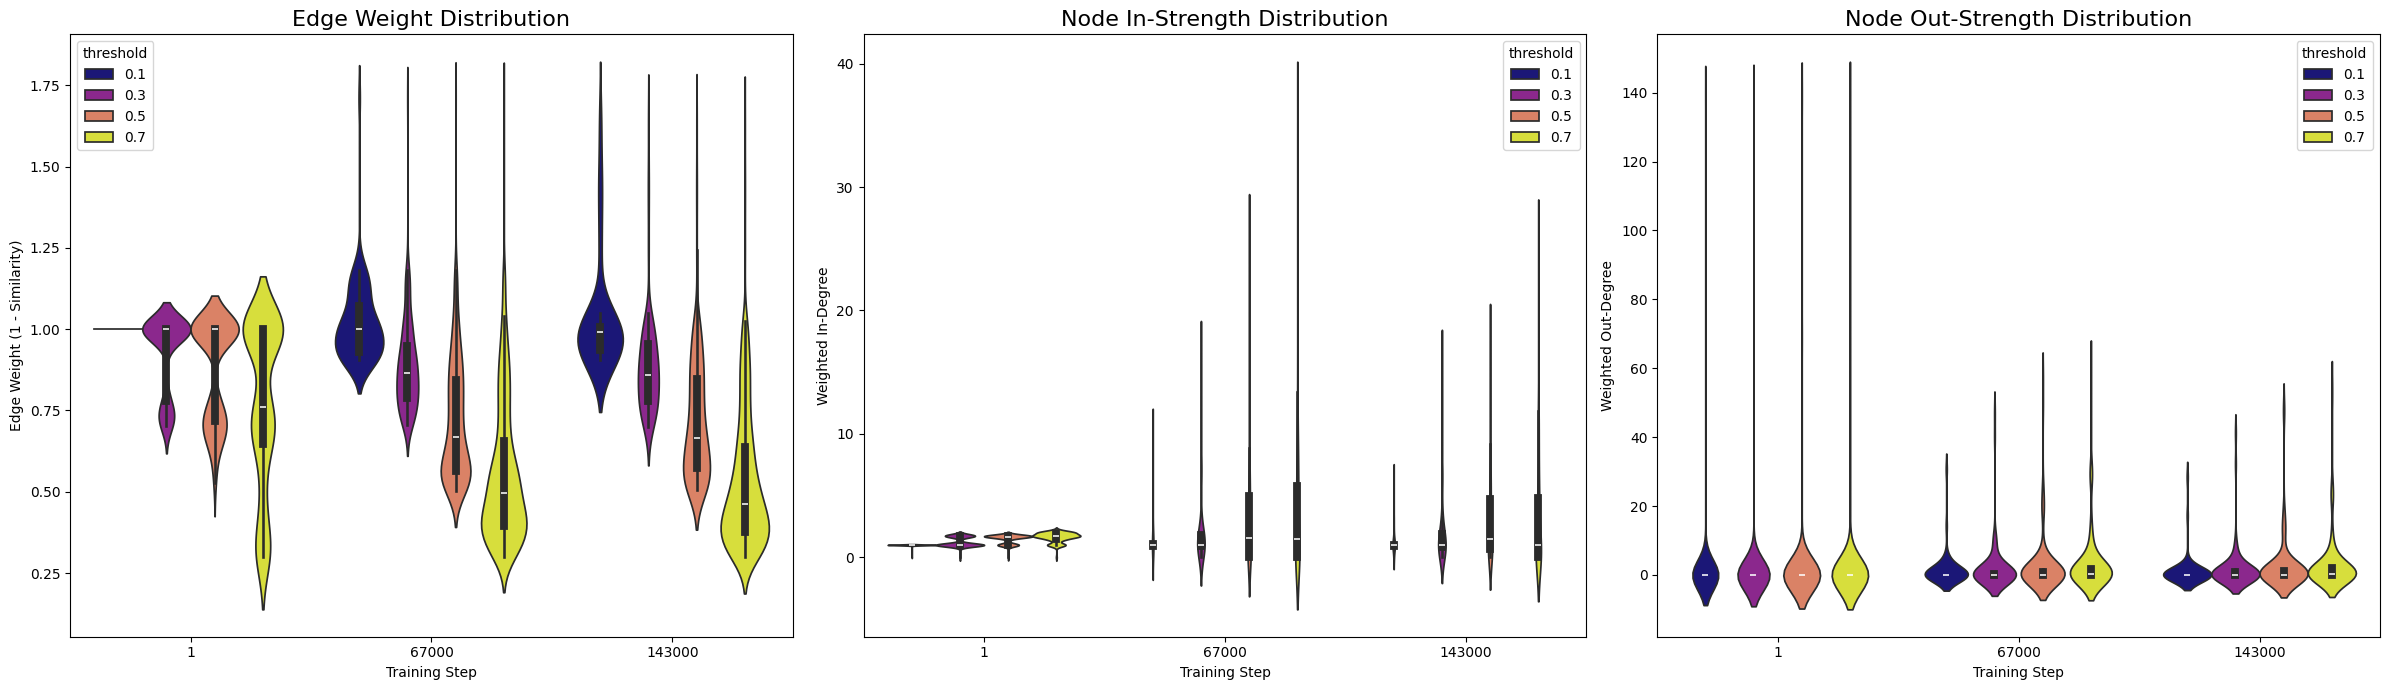

In [38]:
# Generate plots
df_metrics_plot = df_metrics[df_metrics['threshold']<0.9]
plot_metrics_over_time(df_metrics_plot, OUTPUT_DIR)
plot_weight_and_strength_distributions(df_metrics_plot, OUTPUT_DIR)

In [68]:
def plot_individual_distributions(df, save_dir):
    """
    Plots the distribution of weights and strengths as individual PNG files.
    """
    # --- 1. Data Preparation (done once) ---
    # Select first, middle, and last step for comparison
    steps = sorted(df['step'].unique())
    if len(steps) > 2:
        steps_to_plot = [steps[0], steps[len(steps) // 2], steps[-1]]
    else:
        steps_to_plot = steps
    
    df_plot = df[df['step'].isin(steps_to_plot)]

    # --- 2. Plot and Save Edge Weight Distribution ---
    plt.figure(figsize=(10, 7)) # Create a new figure for this plot
    ax1 = plt.gca() # Get the current axis
    
    edge_data = df_plot.explode('edge_weight_dist')
    sns.violinplot(data=edge_data, x='step', y='edge_weight_dist', hue='threshold', ax=ax1, palette='plasma')
    ax1.set_title('Edge Weight Distribution', fontsize=16)
    ax1.set_xlabel('Training Step', fontsize=12)
    ax1.set_ylabel('Edge Weight (1 - Similarity)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    save_path1 = os.path.join(save_dir, 'distribution_edge_weights.png')
    plt.savefig(save_path1, dpi=150)
    plt.close() # Close the figure to free up memory
    print(f"Saved Edge Weight plot to {save_path1}")

    # --- 3. Plot and Save In-Strength Distribution ---
    plt.figure(figsize=(10, 7)) # Create a second figure
    ax2 = plt.gca()
    
    in_strength_data = df_plot.explode('in_strength_dist')
    sns.violinplot(data=in_strength_data, x='step', y='in_strength_dist', hue='threshold', ax=ax2, palette='plasma')
    ax2.set_title('Node In-Strength Distribution', fontsize=16)
    ax2.set_xlabel('Training Step', fontsize=12)
    ax2.set_ylabel('Weighted In-Degree', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    save_path2 = os.path.join(save_dir, 'distribution_in_strength.png')
    plt.savefig(save_path2, dpi=150)
    plt.close()
    print(f"Saved In-Strength plot to {save_path2}")

    # --- 4. Plot and Save Out-Strength Distribution ---
    plt.figure(figsize=(10, 7)) # Create a third figure
    ax3 = plt.gca()
    
    out_strength_data = df_plot.explode('out_strength_dist')
    sns.violinplot(data=out_strength_data, x='step', y='out_strength_dist', hue='threshold', ax=ax3, palette='plasma')
    ax3.set_title('Node Out-Strength Distribution', fontsize=16)
    ax3.set_xlabel('Training Step', fontsize=12)
    ax3.set_ylabel('Weighted Out-Degree', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    save_path3 = os.path.join(save_dir, 'distribution_out_strength.png')
    plt.savefig(save_path3, dpi=150)
    plt.close()
    print(f"Saved Out-Strength plot to {save_path3}")

In [70]:
plot_individual_distributions(df_metrics, OUTPUT_DIR)

Saved Edge Weight plot to analysis_results/distribution_edge_weights.png
Saved In-Strength plot to analysis_results/distribution_in_strength.png
Saved Out-Strength plot to analysis_results/distribution_out_strength.png


In [71]:
def plot_individual_metric_evolutions(df_metrics, save_dir):
    """
    Plots the evolution of each key metric over training steps as an individual PNG file.
    """
    metrics_to_plot = [
        'num_nodes', 'num_edges', 'density', 'avg_in_strength', 'avg_out_strength',
        'avg_betweenness', 'avg_closeness', 'avg_pagerank'
    ]

    # Loop through each metric and create a dedicated plot for it
    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 8)) # Create a new figure for each plot
        ax = plt.gca() # Get the current axis

        sns.lineplot(data=df_metrics, x='step', y=metric, hue='threshold', marker='o', ax=ax, palette='viridis')
        
        # Formatting for a clean, readable plot
        ax.set_title(f'Evolution of {metric.replace("_", " ").title()}', fontsize=18, pad=20)
        ax.set_xlabel('Training Step', fontsize=14)
        ax.set_ylabel(metric.replace("_", " ").title(), fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(title='Threshold')

        plt.tight_layout()
        
        # Create a unique filename for each metric
        save_path = os.path.join(save_dir, f'evolution_{metric}.png')
        plt.savefig(save_path, dpi=150)
        plt.close() # Close the figure to free up memory before the next loop iteration
        
        print(f"Saved plot to {save_path}")

In [74]:
plot_individual_metric_evolutions(df_metrics_plot, OUTPUT_DIR)

Saved plot to analysis_results/evolution_num_nodes.png
Saved plot to analysis_results/evolution_num_edges.png
Saved plot to analysis_results/evolution_density.png
Saved plot to analysis_results/evolution_avg_in_strength.png
Saved plot to analysis_results/evolution_avg_out_strength.png
Saved plot to analysis_results/evolution_avg_betweenness.png
Saved plot to analysis_results/evolution_avg_closeness.png
Saved plot to analysis_results/evolution_avg_pagerank.png


In [ ]:
# --- Configuration for this Analysis Cell ---

# Use the same directories and helper functions from your main script
INPUT_DIR = 'ablation_data'
OUTPUT_DIR = 'analysis_results' # Optional, for saving detailed CSVs

# Define the specific steps and the threshold to investigate
STEPS_TO_ANALYZE = range(80000, 90000, 1000)
ANALYSIS_THRESHOLD = 0.7  # Use a threshold that reveals a meaningful circuit

# Make sure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Assume your helper functions are defined in a previous cell ---
# Ensure `convert_name_to_component` and `get_max_layer_from_df` are available.

# --- Main Analysis Logic ---

for step_num in STEPS_TO_ANALYZE:
    print(f"--- Analyzing Network at Step {step_num} (Threshold={ANALYSIS_THRESHOLD}) ---\n")
    
    # 1. Load the specific data file for the step
    filename = f"step{step_num}.csv"
    file_path = os.path.join(INPUT_DIR, filename)
    
    try:
        df_sim = pd.read_csv(file_path, index_col=0)
    except FileNotFoundError:
        print(f"ERROR: Data file not found: {file_path}")
        continue

    # 2. Build the graph for this step and threshold (same logic as before)
    adj_tuples = []
    low_values = df_sim[df_sim < ANALYSIS_THRESHOLD].stack().reset_index()
    low_values.columns = ['source', 'target', 'similarity']

    for _, row in low_values.iterrows():
        _, source_layer, _ = convert_name_to_component(row['source'])
        _, target_layer, _ = convert_name_to_component(row['target'])
        if source_layer < target_layer:
            adj_tuples.append((row['source'], row['target'], row['similarity']))

    G = nx.DiGraph()
    for source, dest, sim in adj_tuples:
        source_name, source_layer, _ = convert_name_to_component(source)
        target_name, target_layer, _ = convert_name_to_component(dest)
        G.add_node(source_name, layer=source_layer)
        G.add_node(target_name, layer=target_layer)
        G.add_edge(source_name, target_name, weight=(1 - sim), similarity=sim)

    if G.number_of_nodes() == 0:
        print("No graph could be constructed at this threshold. Skipping analysis.")
        continue
        
    betweenness_centrality = nx.betweenness_centrality(G, weight='distance', normalized=True)
    
    # Convert to a DataFrame for easy sorting and display
    df_centrality = pd.DataFrame(
        betweenness_centrality.items(),
        columns=['component', 'betweenness']
    ).sort_values('betweenness', ascending=False)
    
    print("Top 10 Most Central Components (Hubs):")
    print(df_centrality.head(10).to_string(index=False))
    print("-" * 50)

    # 4. Find the Most Prominent Circuits (Edges with High Centrality Nodes)
    
    # We define a "prominent edge" as one connecting two high-centrality nodes
    top_hubs = set(df_centrality.head(20)['component']) # Look at connections between the top 20 hubs
    
    prominent_edges = []
    for u, v, data in G.edges(data=True):
        if u in top_hubs and v in top_hubs:
            # Score the edge based on the centrality of its nodes and its own weight
            edge_score = (betweenness_centrality[u] + betweenness_centrality[v]) * data['weight']
            prominent_edges.append((u, v, data['weight'], edge_score))
            
    # Create a DataFrame for the prominent edges
    df_edges = pd.DataFrame(
        prominent_edges,
        columns=['source', 'target', 'strength', 'prominence_score']
    ).sort_values('prominence_score', ascending=False)
    
    print("Top 10 Most Prominent Circuits (Edges between Hubs):")
    # Using .to_string() for better notebook formatting
    print(df_edges.head(10).to_string(index=False))
    print("\n" + "="*70 + "\n")

    # Optional: Save the detailed centrality data to CSV for further inspection
    centrality_filename = f"centrality_step_{step_num}_thresh_{ANALYSIS_THRESHOLD}.csv"
    df_centrality.to_csv(os.path.join(OUTPUT_DIR, centrality_filename), index=False)

--- Analyzing Network at Step 80000 (Threshold=0.7) ---

Top 10 Most Central Components (Hubs):
   component  betweenness
       mlp_2     0.003102
       mlp_3     0.001119
    attn.z.2     0.000763
    attn.z.4     0.000648
       mlp_4     0.000280
       mlp_0     0.000153
  attn.z.2.3     0.000153
    attn.v.4     0.000038
  attn.z.5.3     0.000000
attn.rot_k.0     0.000000
--------------------------------------------------
Top 10 Most Prominent Circuits (Edges between Hubs):
      source     target  strength  prominence_score
    attn.k.0      mlp_2  0.890137          0.002761
    attn.q.0      mlp_2  0.890137          0.002761
attn.rot_k.0      mlp_2  0.890137          0.002761
attn.rot_q.0      mlp_2  0.890137          0.002761
       mlp_0      mlp_2  0.747978          0.002434
       mlp_2 attn.z.5.0  0.625893          0.001941
       mlp_2 attn.z.5.1  0.525815          0.001631
       mlp_2   attn.z.4  0.364987          0.001369
       mlp_2 attn.z.5.3  0.430808          0.0